In [1]:
#import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
import shutil
import torch


In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
import csv
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
#from torchvision import datasets
from reconstruct_data import restructure_mura_by_bone


# MURA Binary Classification Using CNNs

### Custom Dataset for Nested Structure of MURA

Uncomment to use the restructure fucntion

In [ ]:
base_path = "MURA-v1.1"
output_path = "path_to_restructured_by_bone_MURA"
#restructure_mura_by_bone(base_path, output_path)

###  Data Loading and Transforms

Safe image folder will check for any corruput images.

In [4]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from PIL import Image


class SafeImageFolder(datasets.ImageFolder):
    def __getitem__(self, index):
        try:
            return super().__getitem__(index)
        except (FileNotFoundError, OSError):
            print(f"Skipping corrupt image at index {index}")
            return self.__getitem__((index + 1) % len(self))  # Move to next image
        
def calculate_mean_std(loader):
    mean = 0.0
    std = 0.0
    total_images_count = 0

    for images, _ in loader:
        batch_size = images.size(0)
        num_pixels = batch_size * images.size(2) * images.size(3)  # H * W * Batch
        mean += images.mean([0, 2, 3]) * num_pixels  # Compute per-channel mean
        std += images.std([0, 2, 3]) * num_pixels  # Compute per-channel std
        total_images_count += num_pixels

    mean /= total_images_count
    std /= total_images_count
    return mean, std


In [ ]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
])

In [ ]:

train_dataset = SafeImageFolder(root="path_to_restructured_by_bone_MURA/train/#replace_with_type", transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

mean, std = calculate_mean_std(train_loader)

In [ ]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)

])

train_dataset = SafeImageFolder(root="path_to_restructured_by_bone_MURA/train/#replace_with_type", transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


In [42]:
transform_test = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=0, std = 1), 

])

In [ ]:
valid_dataset = SafeImageFolder(root="path_to_restructured_by_bone_MURA/valid/#replace_with_type", transform=transform_test)
test_loader = DataLoader(valid_dataset, batch_size=32, shuffle=True)

### Random Image Check

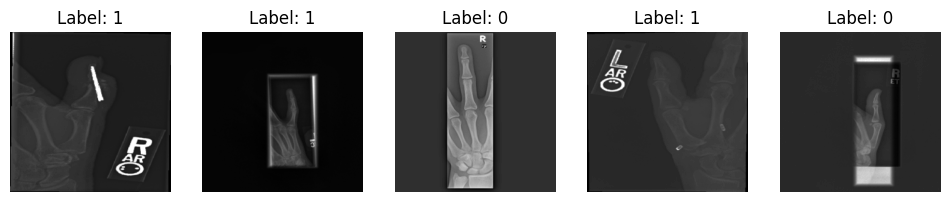

In [44]:
# Get a batch of images
dataiter = iter(train_loader)
images, labels = next(dataiter)
#for image in images:
    #print(image.shape)

# Plot first 5 images
fig, axes = plt.subplots(1, 5, figsize=(12, 3))
for i in range(5):
    axes[i].imshow(images[i].permute(1, 2, 0).squeeze(), cmap="gray")
    axes[i].set_title(f"Label: {labels[i].item()}")
    axes[i].axis("off")
plt.show()

In [45]:
# Example to iterate through the DataLoader
for images, labels in train_loader:
    print(f"Batch Image Shape: {images.shape}, Batch Labels Shape: {labels.shape}")
    break

Batch Image Shape: torch.Size([32, 1, 256, 256]), Batch Labels Shape: torch.Size([32])


In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Base CNN 

In [ ]:
from torch.nn import Module
from torch.nn import Conv2d
from torch.nn import Linear
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import LogSoftmax
from torch import flatten

from tqdm import tqdm 
from cnn_structures import GAP_CNN, SmallStrideCNN, BaseCNN
from train_test import training_loop
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader
from tqdm import tqdm
import random
import wandb

import wandb

from torch.optim.lr_scheduler import ReduceLROnPlateau

### CNN Init

In [20]:
class BaseCNN(nn.Module):
    def __init__(self, num_classes): #num_classes will depend on the MURA task
        super(BaseCNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        self.pool = nn.MaxPool2d(2, 2)

        # Change FC layer for 224x224 input
        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(nn.ReLU()(self.bn1(self.conv1(x))))
        x = self.pool(nn.ReLU()(self.bn2(self.conv2(x))))
        x = self.pool(nn.ReLU()(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)  # Flatten
        x = self.dropout(nn.ReLU()(self.fc1(x)))
        x = self.fc2(x)
        return x

## Training and Evaluation Loop for Base CNN

In [ ]:
num_classes = 2  
num_epochs = 10

In [ ]:


# Assuming train_loader, val_loader, and test_loader are defined

def train_and_evaluate(config):
    model = BaseCNN(num_classes).to('cuda')
    if config['optimizer'] == 'AdamW':
        optimizer = optim.AdamW(model.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])
    elif config['optimizer'] == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])
    elif config['optimizer'] == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])

    criterion = nn.CrossEntropyLoss(label_smoothing=config['label_smoothing'])
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=config['patience'])

    for epoch in tqdm(range(num_epochs)):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to('cuda'), labels.to('cuda')
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Validation
        model.eval()
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to('cuda'), labels.to('cuda')
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_accuracy = 100 * val_correct / val_total
        scheduler.step(running_loss)
        wandb.log({'val_accuracy':val_accuracy, 'train_loss':running_loss/len(train_loader)})
    return val_accuracy



100%|██████████| 10/10 [05:35<00:00, 33.59s/it]


Trial 1/5, Val Accuracy: 50.53763440860215, Config: {'lr': 0.001, 'batch_size': 32, 'optimizer': 'AdamW', 'weight_decay': 0.001, 'label_smoothing': 0.2, 'patience': 2}


 20%|██        | 2/10 [01:22<05:28, 41.11s/it]


KeyboardInterrupt: 

In [ ]:
# Hyperparameter search
num_trials = 5  # Number of random combinations to try
best_accuracy = 0.0
best_config = None

wandb.init(project = "base_cnn_tuning")

for i in range(num_trials):
    config = {
        'lr': random.choice([1e-4, 1e-3, 1e-2, 1e-5]),
        'batch_size': random.choice([16, 32, 64]),
        'optimizer': random.choice(['AdamW', 'Adam', 'SGD']),
        'weight_decay': random.choice([1e-5, 1e-4, 1e-3]),
        'label_smoothing': random.choice([0.0, 0.1, 0.2]),
        'patience': random.choice([2, 4, 6])
    }
    accuracy = train_and_evaluate(config)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_config = config
    print(f"Trial {i+1}/{num_trials}, Val Accuracy: {accuracy}, Config: {config}")

print(f"Best Val Accuracy: {best_accuracy}, Best Config: {best_config}")
wandb.finish()

## Pretrained CNN Model

In [ ]:

import torchvision.models as models


In [46]:
class PretrainedCNN(nn.Module):
    def __init__(self, num_classes):
        super(PretrainedCNN, self).__init__()
        self.base_model = models.resnet18(weights="IMAGENET1K_V1")  # Load pretrained ResNet18
        self.base_model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)  # Adapt for grayscale
        num_ftrs = self.base_model.fc.in_features
        self.base_model.fc = nn.Linear(num_ftrs, num_classes)  # Modify output layer

          # Freeze all layers
        for param in self.base_model.parameters():
            param.requires_grad = False  

        # Unfreeze the last residual block (layer4) and fully connected layer (fc)
        for param in self.base_model.layer4.parameters():  
            param.requires_grad = True

        for param in self.base_model.fc.parameters():
            param.requires_grad = True

    def forward(self, x):
        return self.base_model(x)

### Pretrained Model Training and Evaluation Loop

In [47]:
def train_and_evaluate(config):
    model = PretrainedCNN(num_classes).to('cuda')

    trainable_params = filter(lambda p: p.requires_grad, model.parameters())

    # Optimizer selection
    if config['optimizer'] == 'AdamW':
        optimizer = optim.AdamW(model.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])
    elif config['optimizer'] == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])
    elif config['optimizer'] == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])

    criterion = nn.CrossEntropyLoss(label_smoothing=config['label_smoothing'])
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=config['patience'])

    for epoch in tqdm(range(num_epochs)):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to('cuda'), labels.to('cuda')
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Validation
        model.eval()
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to('cuda'), labels.to('cuda')
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_accuracy = 100 * val_correct / val_total
        scheduler.step(running_loss)
        wandb.log({'val_accuracy': val_accuracy, 'train_loss': running_loss / len(train_loader)})

    return val_accuracy

In [48]:
# Hyperparameter search
num_trials = 10  # Number of random combinations to try
best_accuracy = 0.0
best_config = None

wandb.init(project = "base_cnn_tuning")

for i in range(num_trials):
    config = {
        'lr': random.choice([1e-4, 1e-3, 1e-2, 1e-5]),
        'batch_size': random.choice([16, 32, 64]),
        'optimizer': random.choice(['AdamW', 'Adam', 'SGD']),
        'weight_decay': random.choice([1e-5, 1e-4, 1e-3]),
        'label_smoothing': random.choice([0.0, 0.1, 0.2]),
        'patience': random.choice([2, 4, 6])
    }
    accuracy = train_and_evaluate(config)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_config = config
    print(f"Trial {i+1}/{num_trials}, Val Accuracy: {accuracy}, Config: {config}")

print(f"Best Val Accuracy: {best_accuracy}, Best Config: {best_config}")
wandb.finish()

100%|██████████| 10/10 [04:17<00:00, 25.70s/it]


Trial 1/10, Val Accuracy: 51.409978308026034, Config: {'lr': 0.0001, 'batch_size': 32, 'optimizer': 'AdamW', 'weight_decay': 1e-05, 'label_smoothing': 0.1, 'patience': 2}


100%|██████████| 10/10 [04:19<00:00, 25.98s/it]


Trial 2/10, Val Accuracy: 52.49457700650759, Config: {'lr': 0.0001, 'batch_size': 32, 'optimizer': 'Adam', 'weight_decay': 1e-05, 'label_smoothing': 0.1, 'patience': 2}


 90%|█████████ | 9/10 [04:06<00:27, 27.33s/it]


KeyboardInterrupt: 